### Description of this project

A food company 40 different ad campaigns and want you to help them understand their performance.

In [1]:
%matplotlib notebook
import numpy as np
import pandas as pd
from itertools import product
import sys
import pandas_profiling as pp
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy import stats
import statsmodels
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox

from scipy.ndimage.filters import gaussian_filter1d
from sklearn.cluster import KMeans

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings('ignore')

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True, 'figure.figsize':(5, 2.2), 'legend.loc':'right'})

### 1. Read Data

In [2]:
data = pd.read_csv("ad_table.csv", parse_dates=["date"])
data.head()

date  shown  clicked  converted  avg_cost_per_click  total_revenue  \
0 2015-10-01  65877     2339         43                0.90         641.62   
1 2015-10-02  65100     2498         38                0.94         756.37   
2 2015-10-03  70658     2313         49                0.86         970.90   
3 2015-10-04  69809     2833         51                1.01         907.39   
4 2015-10-05  68186     2696         41                1.00         879.45   

           ad  
0  ad_group_1  
1  ad_group_1  
2  ad_group_1  
3  ad_group_1  
4  ad_group_1

In [3]:
data.dtypes

date                  datetime64[ns]
shown                          int64
clicked                        int64
converted                      int64
avg_cost_per_click           float64
total_revenue                float64
ad                            object
dtype: object

### 2. Exploratory Data Analysis

In [4]:
data.describe(include="all")

date          shown       clicked    converted  \
count                  2115    2115.000000   2115.000000  2115.000000   
unique                   53            NaN           NaN          NaN   
top     2015-11-20 00:00:00            NaN           NaN          NaN   
freq                     40            NaN           NaN          NaN   
first   2015-10-01 00:00:00            NaN           NaN          NaN   
last    2015-11-22 00:00:00            NaN           NaN          NaN   
mean                    NaN   68299.844444   3056.077069   126.453901   
std                     NaN   48884.821409   3783.579969   233.420826   
min                     NaN       0.000000      0.000000     0.000000   
25%                     NaN   28030.500000    744.000000    18.000000   
50%                     NaN   54029.000000   1392.000000    41.000000   
75%                     NaN   97314.500000   3366.500000   103.000000   
max                     NaN  192507.000000  20848.000000  1578.000000   

        avg_cost_per_click  total_revenue           ad  
count          2115.000000    2115.000000         2115  
unique                 NaN            NaN           40  
top                    NaN            NaN  ad_group_16  
freq                   NaN            NaN           53  
first                  NaN            NaN          NaN  
last                   NaN            NaN          NaN  
mean              1.373749    1966.517589          NaN  
std               0.754331    3942.018757          NaN  
min               0.000000    -200.150000          NaN  
25%               0.760000     235.470000          NaN  
50%               1.400000     553.300000          NaN  
75%               1.920000    1611.495000          NaN  
max               4.190000   39623.710000          NaN

<IPython.core.display.Javascript object>


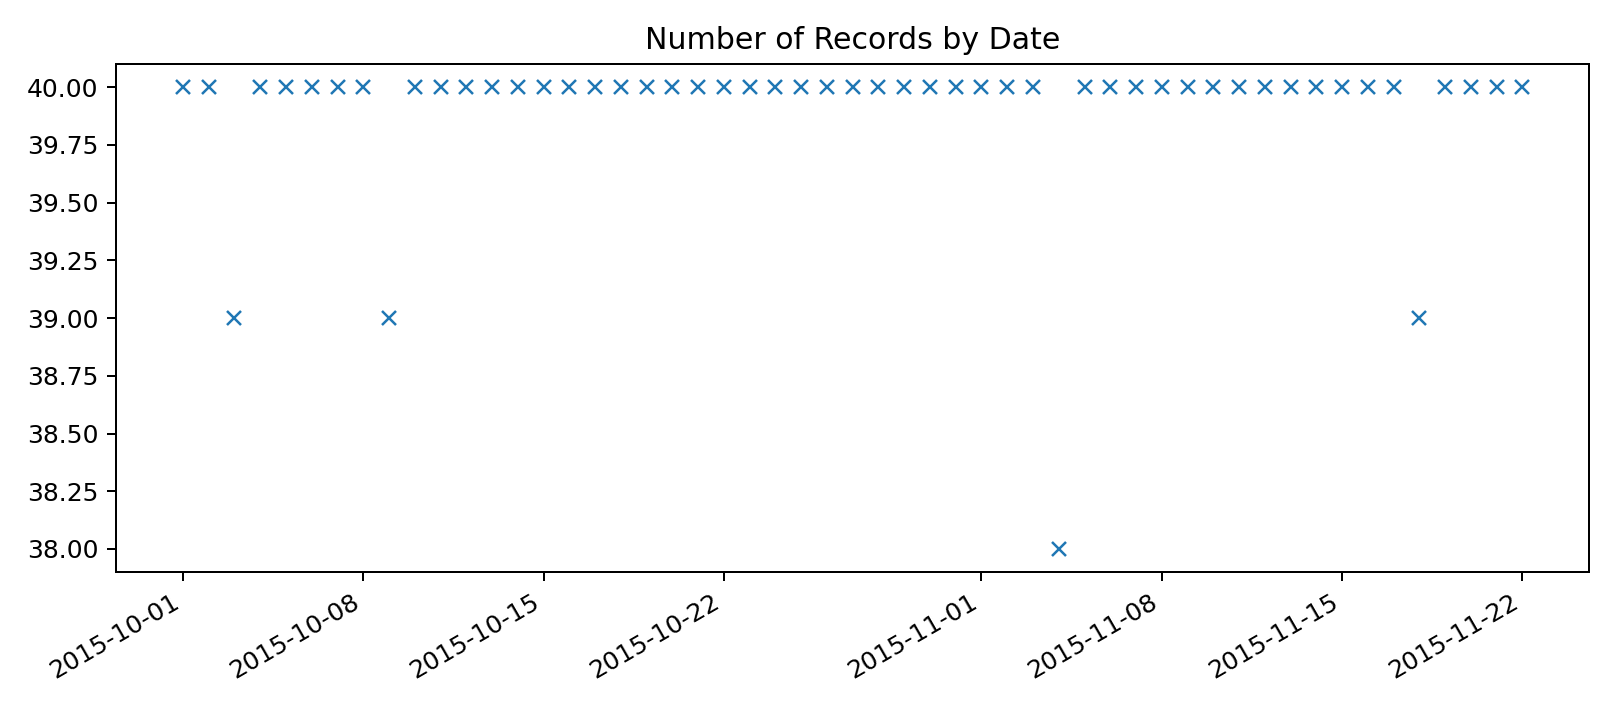

<AxesSubplot:>

Text(0.5, 1.0, 'Number of Records by Date')

In [5]:
%matplotlib notebook
data.date.value_counts().plot(style="x")
plt.title("Number of Records by Date")

Out of the 53 dates, there are 40 measurements for most of the dates and 39 or 38 measurements for only 4 dates. We can assume the data are collected evenly through out the measurement window.

In [6]:
data.ad.value_counts().tail()

ad_group_10    52
ad_group_20    52
ad_group_18    52
ad_group_24    52
ad_group_14    52
Name: ad, dtype: int64

<IPython.core.display.Javascript object>


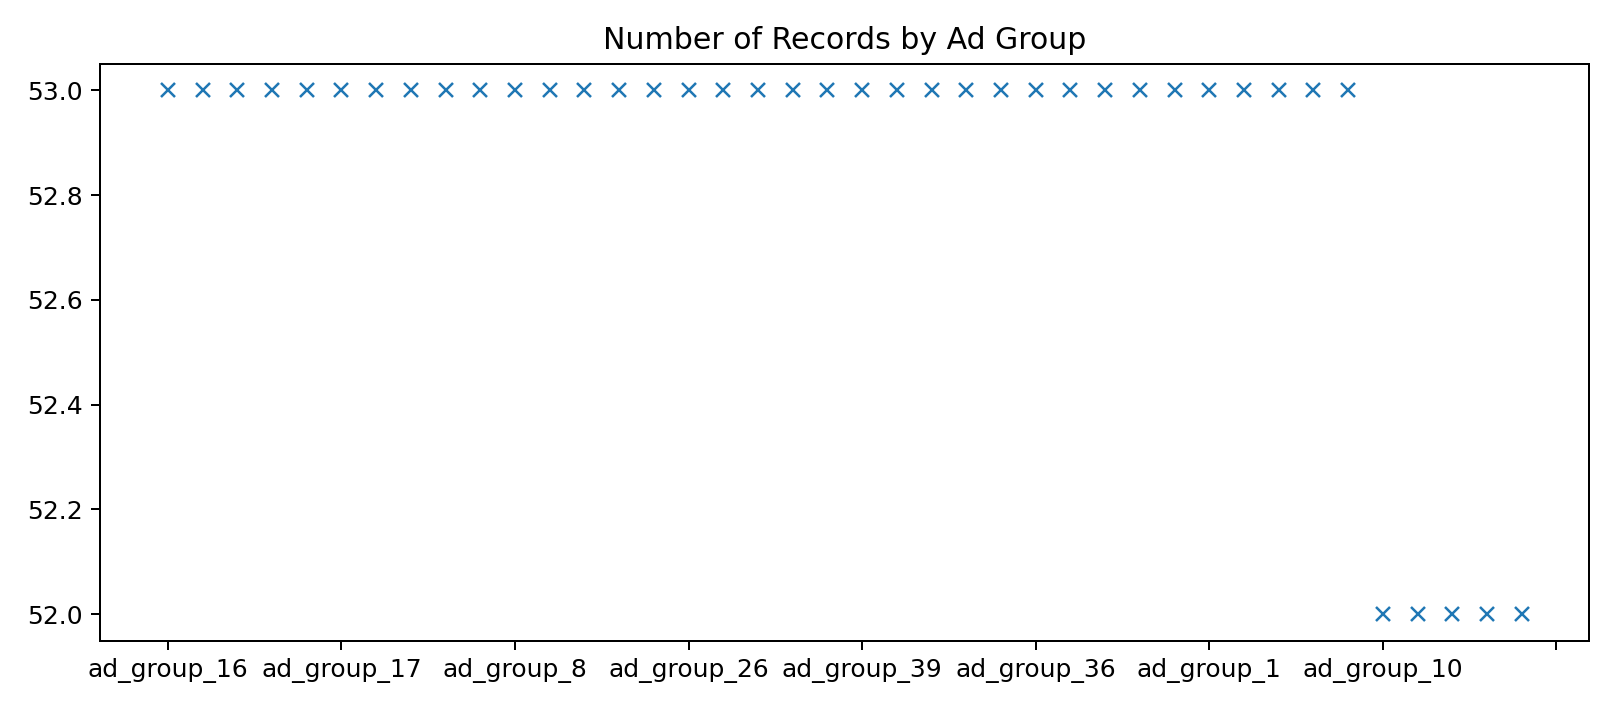

<AxesSubplot:>

Text(0.5, 1.0, 'Number of Records by Ad Group')

In [7]:
%matplotlib notebook
data.ad.value_counts().plot(style='x')
plt.title("Number of Records by Ad Group")

Out of the 40 ad groups, 35 ad groups have 53 data points and 5 ad groups (ad groups 10, 24, 18, 14, 20) have 52 data points, we can assume there are roughly equal number of measurements collected for each ad group.

### 3. Questions
#### Part 1:
If you had to identify the 5 best ad groups, which ones would they be? Which metric did you choose to identify the best ad groups? Why? Explain the pros of your metric as well as the possible cons.

In [8]:
data["profit"] = data["total_revenue"] - data["converted"] * data["avg_cost_per_click"]
data.head(1)

date  shown  clicked  converted  avg_cost_per_click  total_revenue  \
0 2015-10-01  65877     2339         43                 0.9         641.62   

           ad  profit  
0  ad_group_1  602.92

In [9]:
# metric chosen to judge how good an ad group: (total profit) / (total shown)
profit_per_ad_event = data.groupby("ad").apply(lambda df: df["profit"].sum() / df["shown"].sum()).reset_index()
profit_per_ad_event = profit_per_ad_event.rename(columns={0: 'profit_per_ad_event'})
profit_per_ad_event.sort_values("profit_per_ad_event", ascending=False).head()

ad  profit_per_ad_event
4   ad_group_13             0.113963
27  ad_group_34             0.100882
9   ad_group_18             0.098956
3   ad_group_12             0.073785
33   ad_group_4             0.066158

For the metric chosen to judge how good an ad group, I used profit_per_ad_event = (total profit) / (total shown). 
The pro is that it calculate the profit per ad event and it will be robust if there are less measurements collected for certain ad groups (as compared to the total profit). 

The con is that one cannot compare the overall profit for each ad group. Another con is that there are different type of ad events (as defined by a combination of device type, placement, campaign, creative and site) in a ad group, and we cannot tell which particular event in that ad group is bringing the average number up (profit_per_ad_event) and which is brining the average number down.

#### Part 2:
For each group, predict how many ads will be shown on Dec, 15 (assume each ad group keeps following its trend).

In [10]:
import pandas as pd

data = pd.read_csv("ad_table.csv", parse_dates=["date"])
time_series = data.groupby("ad")\
.apply(lambda df: df[["date","shown"]].sort_values("date").set_index("date")).unstack(0)
time_series.head()

shown                                                  \
ad         ad_group_1 ad_group_10 ad_group_11 ad_group_12 ad_group_13   
date                                                                    
2015-10-01    65877.0     97590.0     16451.0     26000.0    162075.0   
2015-10-02    65100.0    101799.0     17699.0     26456.0    156520.0   
2015-10-03    70658.0    102065.0     17786.0     29113.0    158721.0   
2015-10-04    69809.0    104539.0     16349.0     27088.0    168742.0   
2015-10-05    68186.0    108520.0     17703.0     27250.0    172151.0   

                                                                        ...  \
ad         ad_group_14 ad_group_15 ad_group_16 ad_group_17 ad_group_18  ...   
date                                                                    ...   
2015-10-01      8556.0     14811.0     29364.0    119141.0     75128.0  ...   
2015-10-02      8086.0     15326.0     28636.0    122091.0     82618.0  ...   
2015-10-03      7708.0     16063.0     30257.0    125866.0     91208.0  ...   
2015-10-04      7665.0     15156.0     29979.0    117050.0     79333.0  ...   
2015-10-05      7719.0     15088.0     30600.0    126830.0     88208.0  ...   

                                                                       \
ad         ad_group_37 ad_group_38 ad_group_39 ad_group_4 ad_group_40   
date                                                                    
2015-10-01     64526.0    171855.0     21868.0    76786.0     67611.0   
2015-10-02     68744.0    158942.0     23487.0    81869.0     71018.0   
2015-10-03     66879.0    174593.0     21925.0    83304.0     75323.0   
2015-10-04     71882.0    163974.0     21892.0    89154.0     74099.0   
2015-10-05     69156.0    171412.0     23877.0    83704.0     74188.0   

                                                                   
ad         ad_group_5 ad_group_6 ad_group_7 ad_group_8 ad_group_9  
date                                                               
2015-10-01    44544.0    33559.0    48431.0    38089.0   102898.0  
2015-10-02    46663.0    35711.0    51042.0    37322.0   110227.0  
2015-10-03    47227.0    37048.0    48027.0    36878.0   109790.0  
2015-10-04    47088.0    37934.0    51300.0    35019.0   111172.0  
2015-10-05    43155.0    34870.0    49241.0    38195.0   120625.0  

[5 rows x 40 columns]

In [11]:
group_ad_min_dates = data.groupby("ad").apply(lambda df: df.date.min())
print(group_ad_min_dates.min(), group_ad_min_dates.max())

2015-10-01 00:00:00 2015-10-01 00:00:00


In [12]:
group_ad_max_dates = data.groupby("ad").apply(lambda df: df.date.max())
print(group_ad_max_dates.min(), group_ad_max_dates.max())

2015-11-22 00:00:00 2015-11-22 00:00:00


In [13]:
(pd.to_datetime("2015-11-22") - pd.to_datetime("2015-10-01") ).days + 1

53

From above, the starting and ending date of each series are 2015-10-01 and 2015-11-22. However, we know there are 5 ad groups have 1 less data point. Thus, some time series have missing data.

<IPython.core.display.Javascript object>


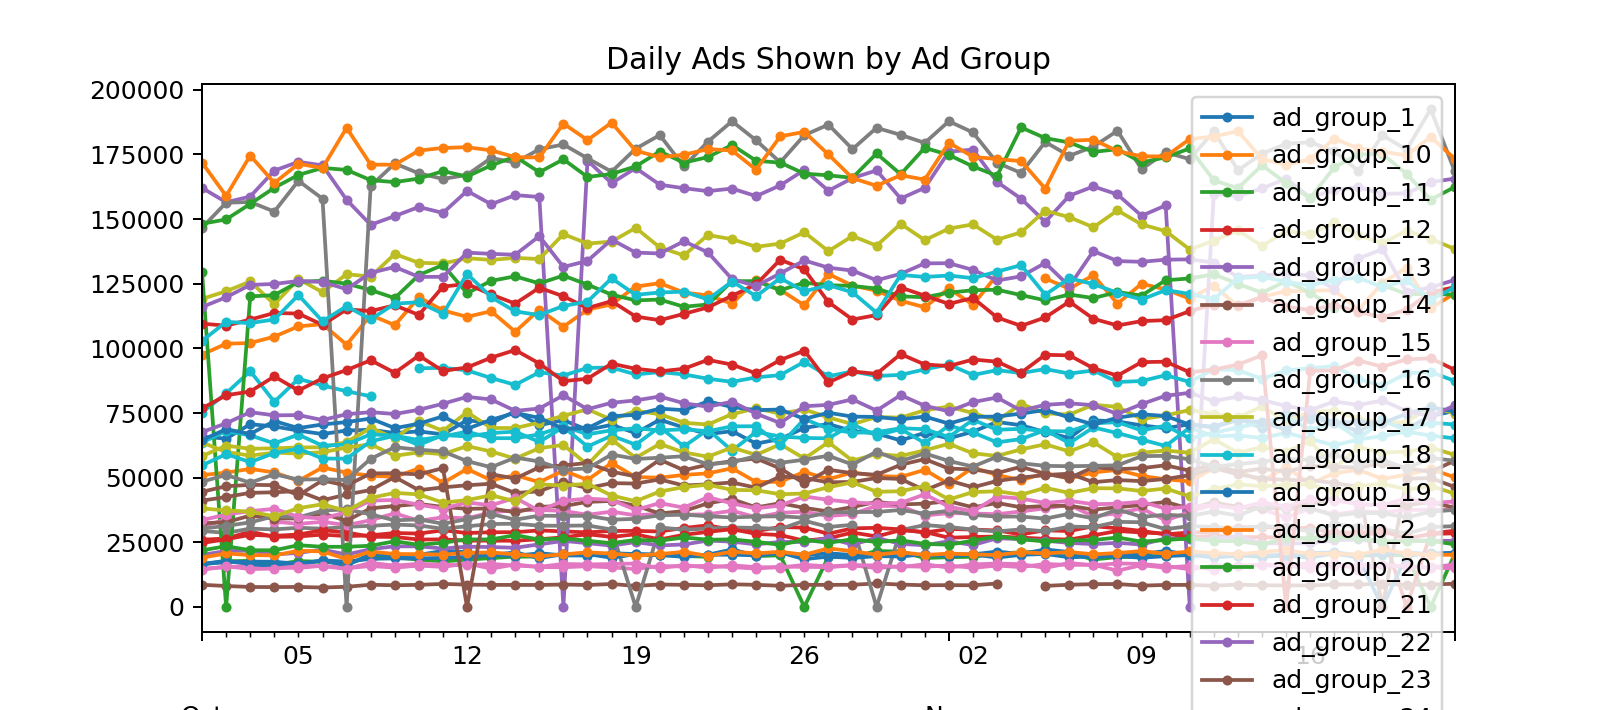

<AxesSubplot:xlabel='date'>

Text(0.5, 1.0, 'Daily Ads Shown by Ad Group')

In [14]:
time_series.plot(style=".-")
plt.legend([y for x,y in time_series.columns], loc='upper right')
plt.title("Daily Ads Shown by Ad Group")

From the plot of the time series, most time series have no aparrent trend across the measurement window, and the missing data points are easy to detect. In addition, those zeros in the time series may also be missing data points. I will use linear interpolation to impute the missing values.

<IPython.core.display.Javascript object>


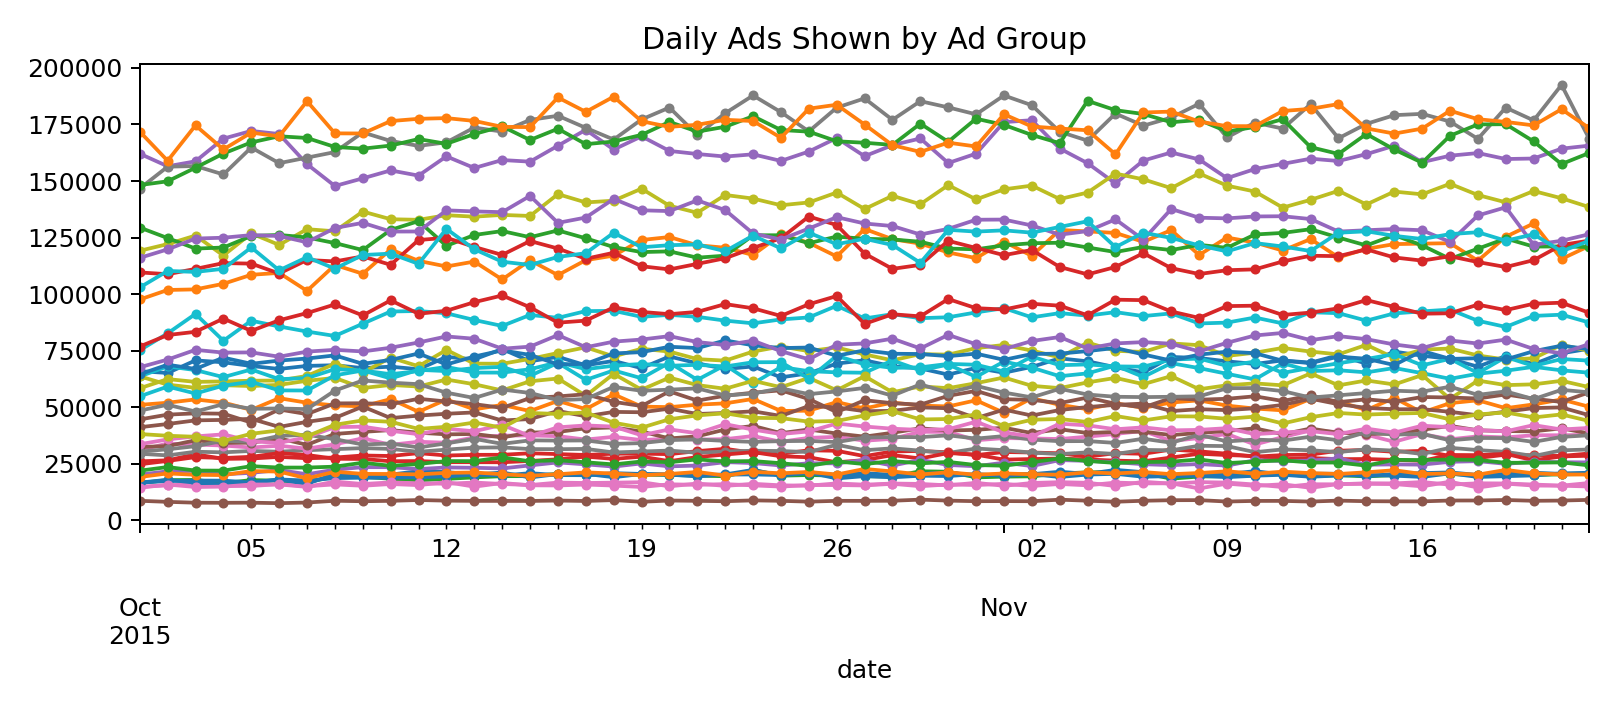

Text(0.5, 1.0, 'Daily Ads Shown by Ad Group')

In [15]:
tss = time_series.stack()
tss[tss.shown==0]= np.nan
time_series = tss.unstack().apply(lambda s: s.interpolate(), axis=0)
ax = time_series.plot(style=".-")
ax.get_legend().remove()
plt.title("Daily Ads Shown by Ad Group")

In [16]:
total_shown = time_series.sum()

In [17]:
min_shown_ad = total_shown.idxmin()
max_shown_ad = total_shown.idxmax()
print(min_shown_ad, max_shown_ad)

('shown', 'ad_group_14') ('shown', 'ad_group_38')


In [18]:
med_shown_ad = np.abs(total_shown-total_shown.median()).idxmin()

<IPython.core.display.Javascript object>


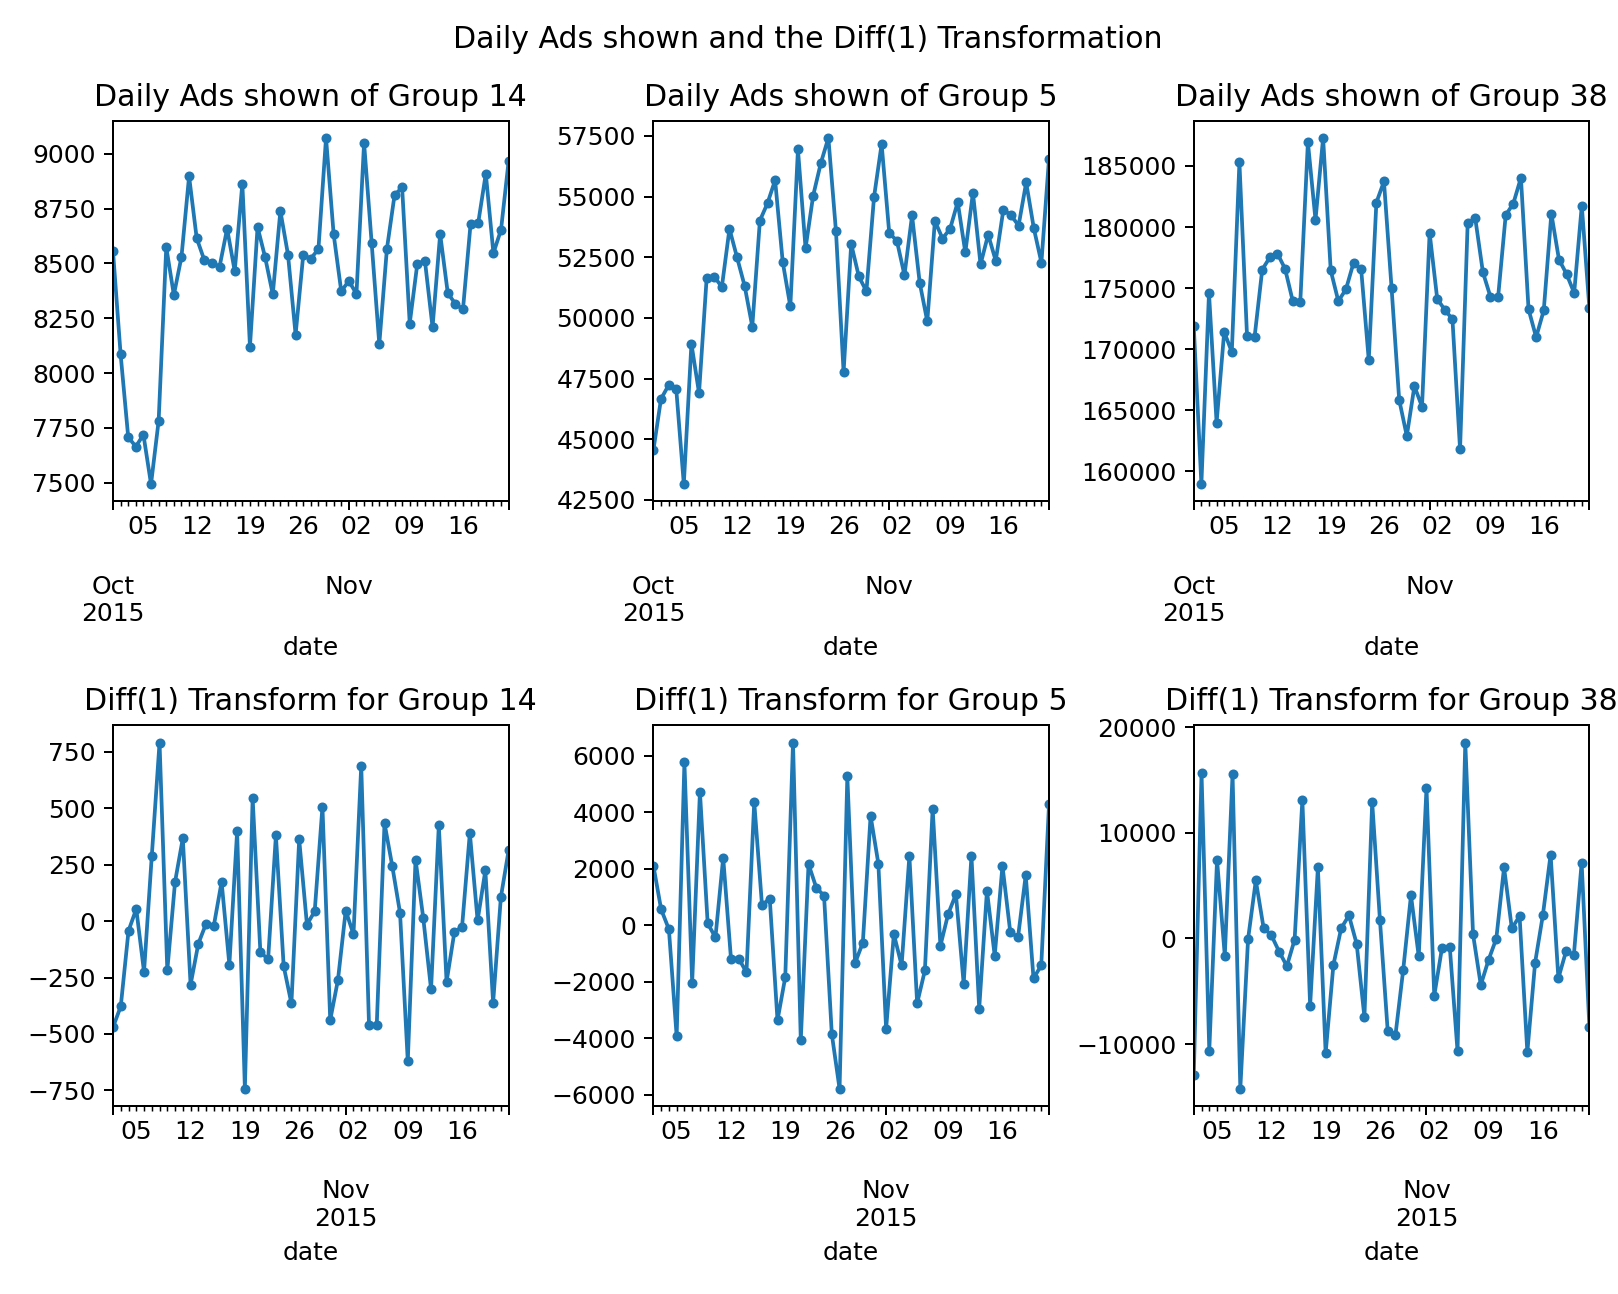

In [19]:
# case analysis of the Ad Group with Minimum Total Ads Shown
mins = time_series[min_shown_ad]
mins_diff1 = mins.diff(1).dropna()
meds = time_series[med_shown_ad]
meds_diff1 = meds.diff(1).dropna()
maxs = time_series[max_shown_ad]
maxs_diff1 = maxs.diff(1).dropna()

fig, axs = plt.subplots(2,3, figsize=(5,4))
_ = fig.suptitle('Daily Ads shown and the Diff(1) Transformation')
_ = mins.plot(style=".-", ax=axs[0][0], title="Daily Ads shown of Group 14")
_ = mins_diff1.plot(style=".-", ax=axs[1][0], title="Diff(1) Transform for Group 14")

_ = meds.plot(style=".-", ax=axs[0][1], title="Daily Ads shown of Group 5")
_ = meds_diff1.plot(style=".-", ax=axs[1][1], title="Diff(1) Transform for Group 5")

_ = maxs.plot(style=".-", ax=axs[0][2], title="Daily Ads shown of Group 38")
_ = maxs_diff1.plot(style=".-", ax=axs[1][2], title="Diff(1) Transform for Group 38")

From the most shown (Ad Group 14) the median shown (Ad Group 5) and least shown ad groups (Ad Group 38), it is found there are trends of growing ads shown (by day). After detrending using Diff(1) transformation, these trends can be completedly removed. So Diff(1) tansformation is desired. However, since the time trend is not always apparent, e.g., from Nov 07, 2020 in Ad Group 5, the no differencing model willl still be considered.

In [20]:
from statsmodels.tsa.stattools import adfuller
def adfuller_test(ts):
    ad_fuller_result = adfuller(ts)
    print('ADF Statistic: {}'.format(ad_fuller_result[0]))
    print('p-value: {}\n'.format(ad_fuller_result[1]))
for ts in [mins, meds, maxs, mins_diff1, meds_diff1, maxs_diff1]:
    adfuller_test(ts)

ADF Statistic: -3.896343558420584
p-value: 0.0020619219011552194

ADF Statistic: -4.07970828012937
p-value: 0.0010460883968136277

ADF Statistic: -5.396313675164302
p-value: 3.4481163504532667e-06

ADF Statistic: -5.068315177616497
p-value: 1.6228229775388625e-05

ADF Statistic: -5.013637064046886
p-value: 2.0854513861421707e-05

ADF Statistic: -6.042305799245247
p-value: 1.3369585350470189e-07



The Dickey–Fuller test above shows: null hypothesis that a unit root is present in an autoregressive model (a time series model being non-stationary) is rejected by all the six time series, with p-values smaller in general after the Diff(1) transformation. This confirms the finding in the previous paragraph.

<IPython.core.display.Javascript object>


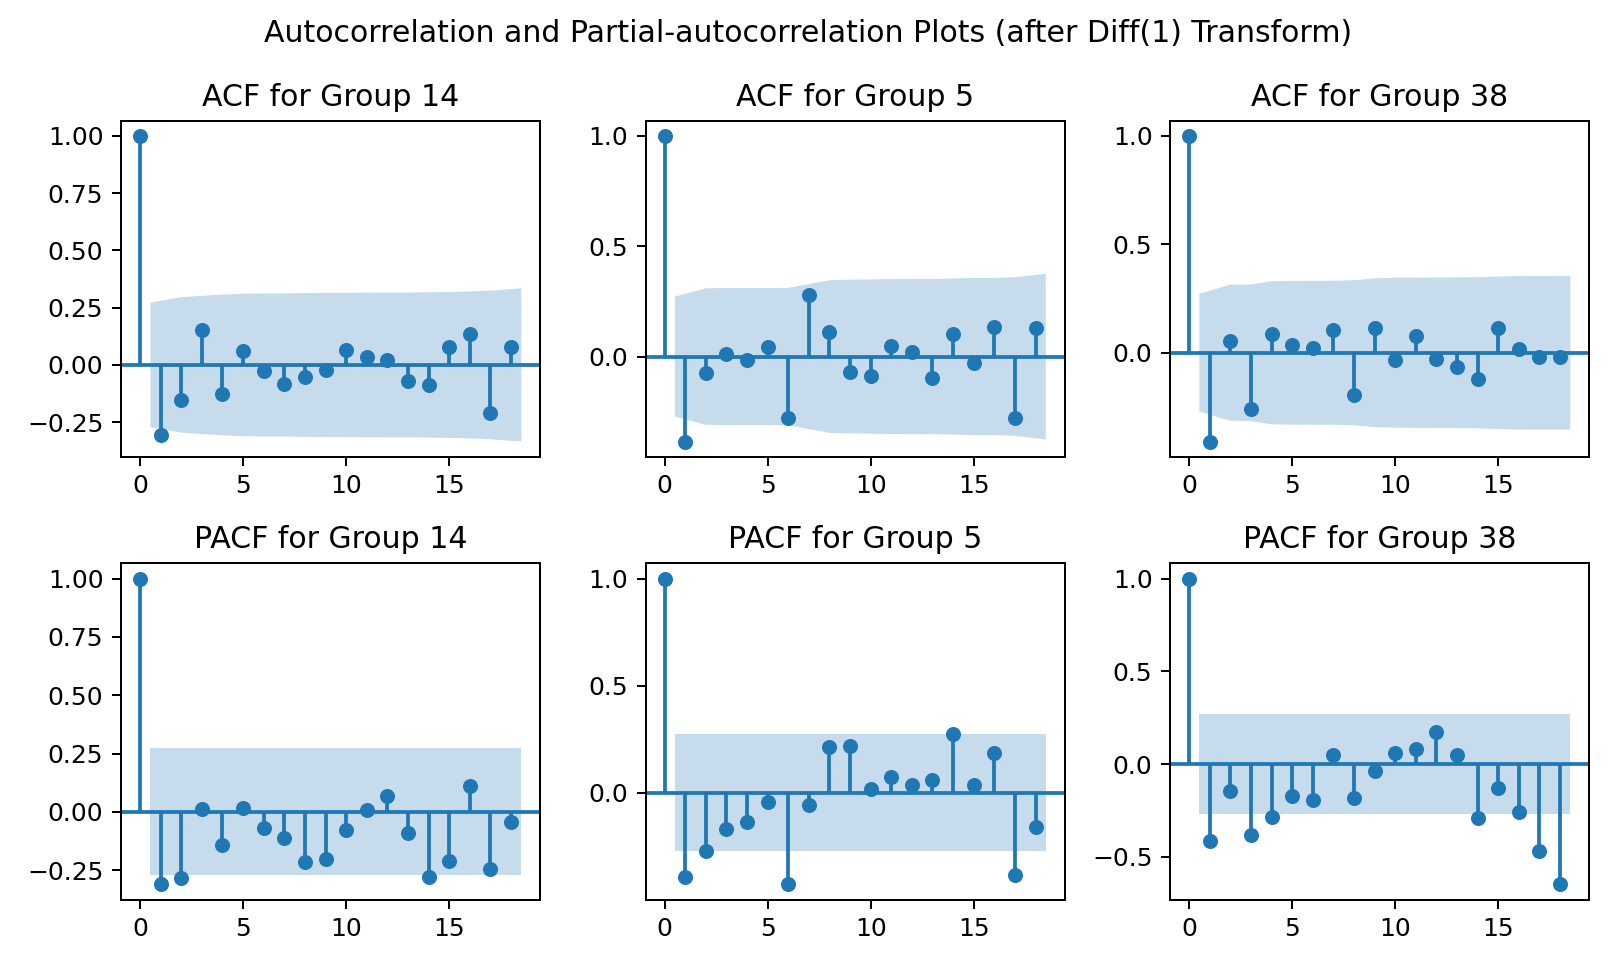

In [21]:
fig, axs = plt.subplots(2,3, figsize=(5,3))
_ = fig.suptitle('Autocorrelation and Partial-autocorrelation Plots (after Diff(1) Transform)')
_ = plot_acf(mins_diff1, ax=axs[0][0], title="ACF for Group 14")
_ = plot_pacf(mins_diff1, ax=axs[1][0], title="PACF for Group 14")
_ = plot_acf(meds_diff1, ax=axs[0][1], title="ACF for Group 5")
_ = plot_pacf(meds_diff1, ax=axs[1][1], title="PACF for Group 5")
_ = plot_acf(maxs_diff1, ax=axs[0][2], title="ACF for Group 38")
_ = plot_pacf(maxs_diff1, ax=axs[1][2], title="PACF for Group 38")

From the Autocorrelation Function (ACF) plots, I find in each of the three time series (after Diff(1)) a significant order=1 moving average process. And the auto-correlations, indicating seasonal moving average pattern, are not large enough to become significant (even in group 5, where autocorrelation of lag 7 is fairly large). 

From the Partial Autocorrelation Function (PACF) plots, I find in each of the three time series a significant moving average process with order >= 1. And Some seasonalities are shown on week 7 or week 14. 

In summary, its nice to try models with SARIMA(p={0,1,2}, d={1}, q={0,1,2})(P={0,1}, D={0,1}, Q={0,1})7, 36 models for each time series. Then I will use the minimum AIC to determine the final SARIMA model for each time series.

In [22]:
class AdGroup(object):
    
    def __init__(self, ad_group_id):
        self.ad_group_id = ad_group_id
        self.parameters_list = []
        self.result_df = None
        self.best_model = None
        self.predictions = None # predict the values on the existing time points
        self.forecast = None # forecast the values on the future time points
        
    def set_SAMRIMA_orders(self, p, d, q, P, D, Q, s):

        if not all(type(x)==list for x in [p, d, q, P, D, Q, s]):
            self.parameters_list = [[y[0] if type(y)==list else y for y in [p, d, q, P, D, Q, s]]]
        else:
            self.parameters_list = list(product(p, d, q, P, D, Q, s))

    def auto_SARIMA_fit(self, time_series):

        results = []
        best_model_aic = sys.maxsize
        best_model = None
        for param in self.parameters_list:
            try: 
                model = SARIMAX(time_series, order=(param[0], param[1], param[2]), 
                                seasonal_order=(param[3], param[4], param[5], param[6])).fit(disp=True)
            except:
                continue

            aic = model.aic
            results.append([param, aic])
            if best_model_aic > model.aic:
                best_model = model
                best_model_aic = model.aic

        result_df = pd.DataFrame(results)
        result_df.columns = ['(p,d,q)x(P,D,Q)s', 'AIC']
        #Sort in ascending order, lower AIC is better
        self.result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
        self.best_model = best_model

    def best_SARIMA_model_forecast(self, steps):
        self.predictions = self.best_model.fittedvalues
        self.forecast = self.best_model.forecast(steps=steps)
        self.predictions[:7 + 1] = np.NaN
        return self.predictions.append(self.forecast)

In [23]:
p = [0, 1, 2]
d = [1]
q = [0, 1, 2] 
P = [0, 1]
D = [0, 1] 
Q = [0, 1]
s = [7]

ad_ids = ["ad_group_{}".format(x) for x in [14, 5, 38]]
# ss = [mins, meds, maxs]
AdGroups = {}
Forecasts = {}

In [24]:
for column_name in ad_ids: # time_series.shown.columns:
    obj = AdGroup(column_name)
    obj.set_SAMRIMA_orders(p, d, q, P, D, Q, s)
    ts = time_series.shown[column_name]
    obj.auto_SARIMA_fit(ts)
    AdGroups[column_name] = obj
    Forecasts[column_name] = obj.best_SARIMA_model_forecast(steps=23)

<IPython.core.display.Javascript object>


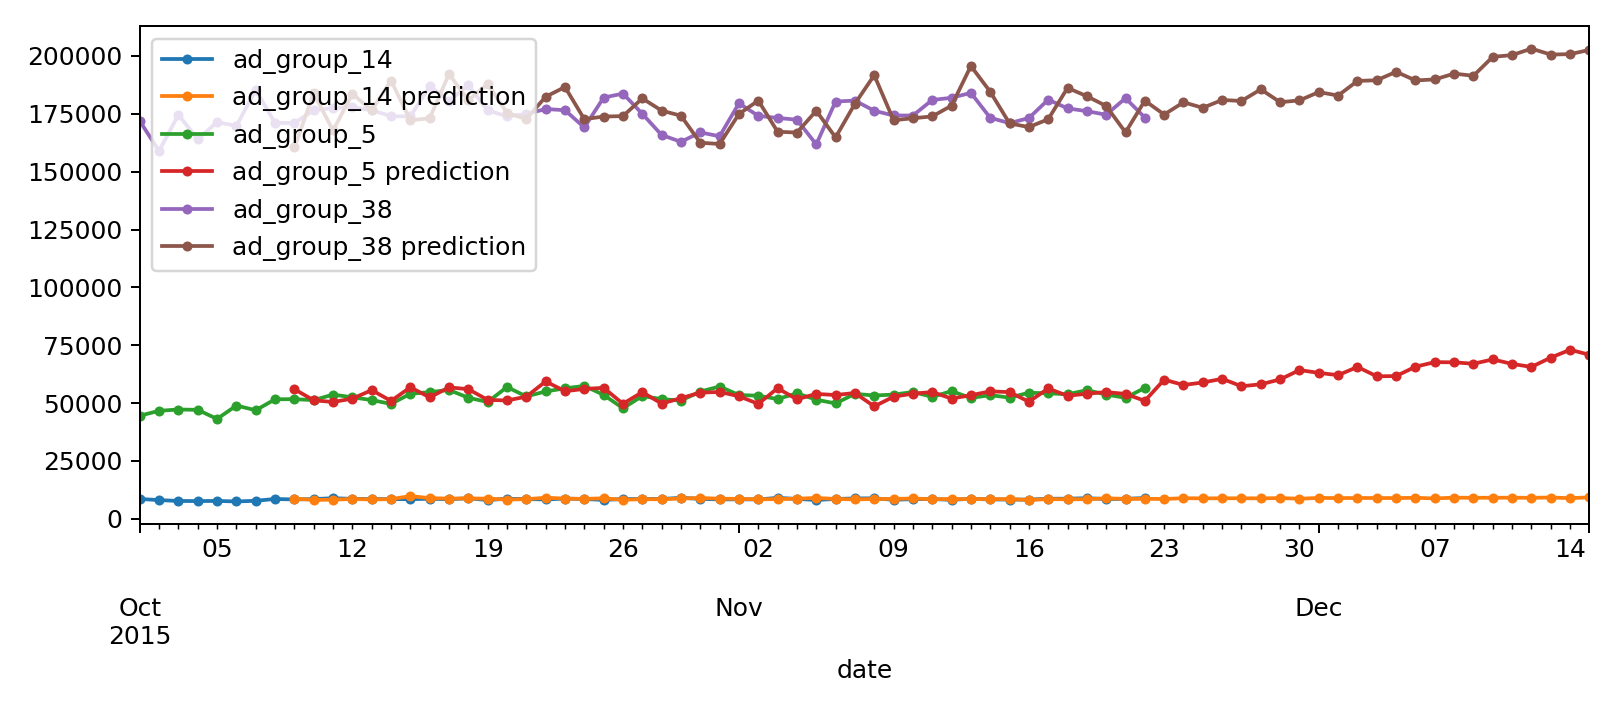

(p,d,q)x(P,D,Q)s         AIC
0  (0, 1, 1, 0, 1, 1, 7)  669.960609

(p,d,q)x(P,D,Q)s         AIC
0  (2, 1, 2, 1, 1, 0, 7)  850.500943

(p,d,q)x(P,D,Q)s         AIC
0  (0, 1, 0, 1, 1, 1, 7)  948.705516

In [25]:
%matplotlib notebook
for column_name in ad_ids:
    _ = time_series.shown[column_name].plot(style=".-")
    _ = Forecasts[column_name].plot(style=".-", label="{} prediction".format(column_name))
    AdGroups[column_name].result_df.head(1)
plt.legend(loc="upper left")

The predicted values on Dec.15 2015 looks reasonable for the 3 selected ad groups, let's do the SARIMA model fitting of all the time series.

P-value of the Ljung-Box Tests of Autocorrelation of Residuals (ad_group_14):


array([0.99999879])

<IPython.core.display.Javascript object>


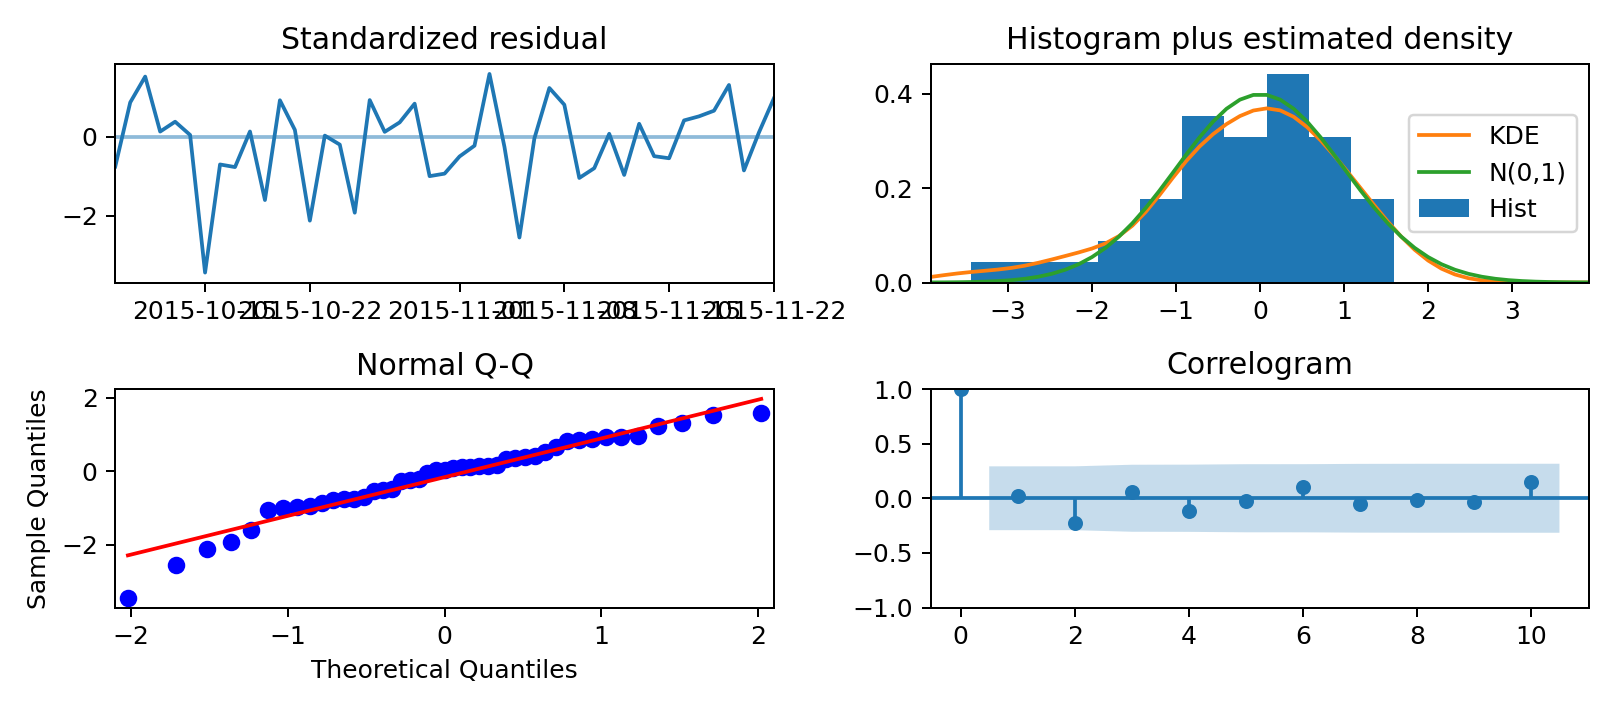

P-value of the Ljung-Box Tests of Autocorrelation of Residuals (ad_group_5):


array([0.89750643])

<IPython.core.display.Javascript object>


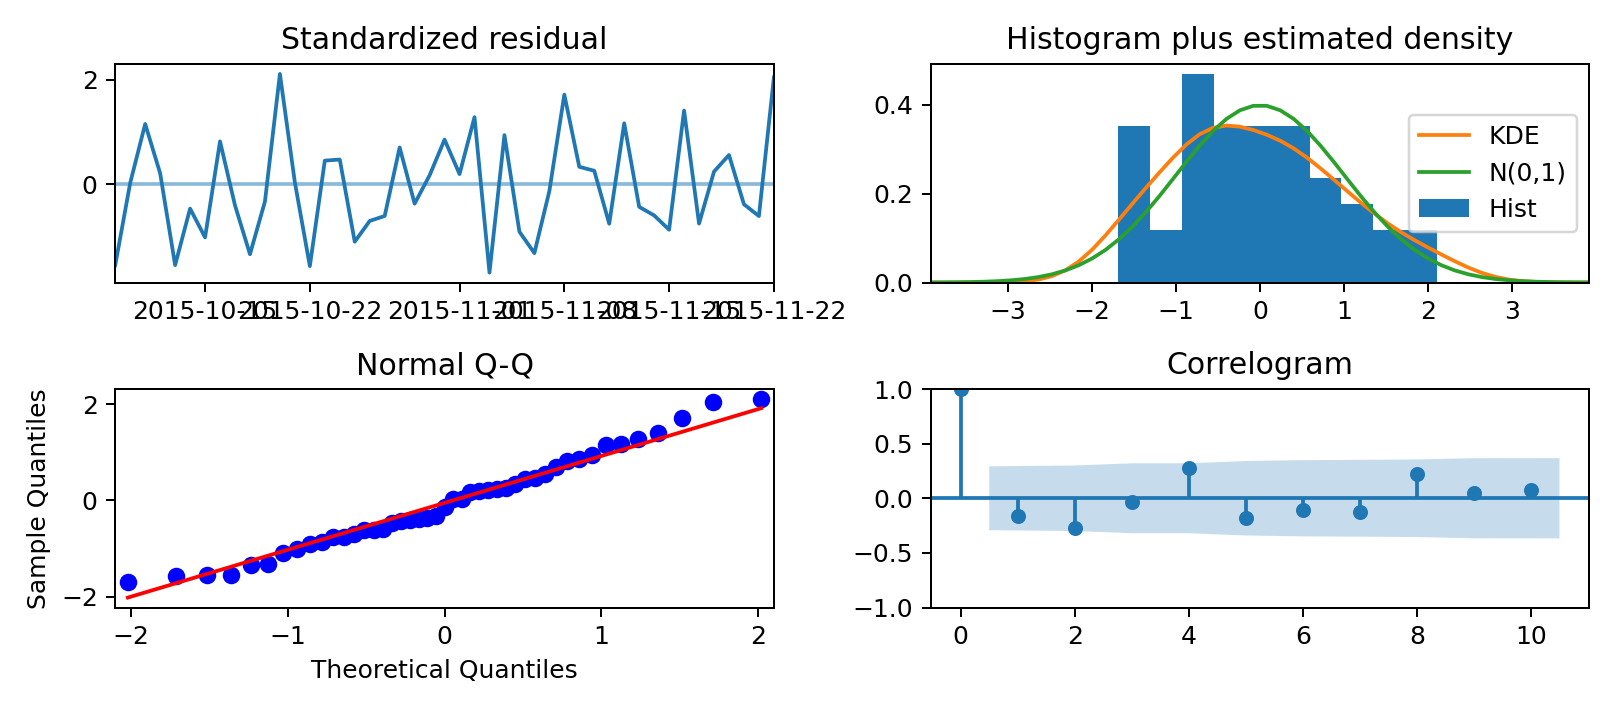

P-value of the Ljung-Box Tests of Autocorrelation of Residuals (ad_group_38):


array([0.98802918])

<IPython.core.display.Javascript object>


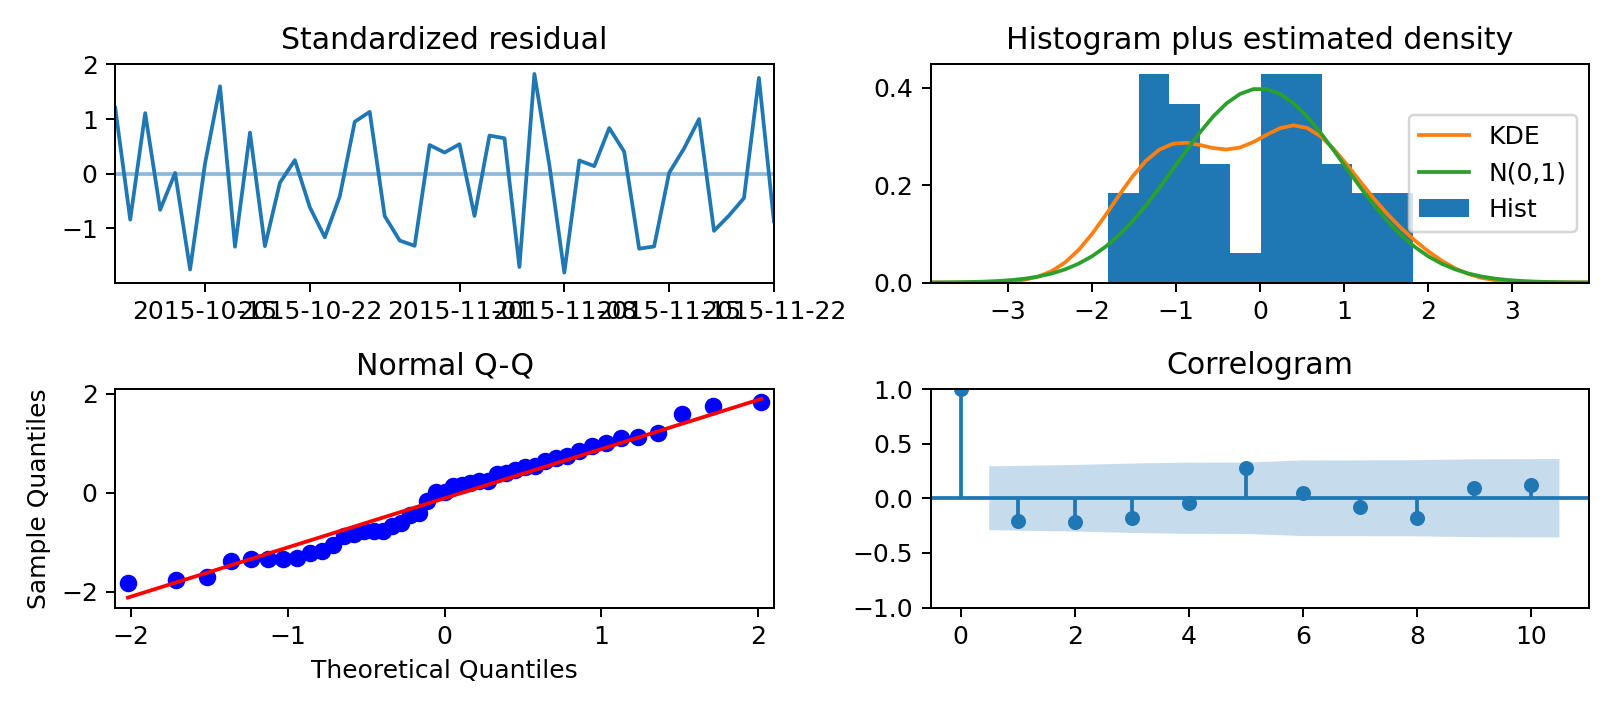

In [30]:
for column_name in ad_ids:
    print("P-value of the Ljung-Box Tests of Autocorrelation of Residuals ({}):".format(column_name))
    acorr_ljungbox(AdGroups[column_name].best_model.resid, lags=[time_series.shape[0] - 1])[1]
    _ = AdGroups[column_name].best_model.plot_diagnostics()

The above include the Ljung-Box tests of autocorrelation of residuals, combined with other visualizations for checking normalities and autocorrelations (the fitted time series model of ad_group_14, ad_group_5 and ad_group_38). From the Ljung-Box test p-values and the correlograms, we find there's no autocorrelation in the residuals given any of the three models. From the Historgrams and Normal Q-Q plots, we find there's normal (or close-to-normal) distribution of the residuals. Thus, the class AdGroup is a valid code implementation to create legitimate time series models. In the following time series models will be biult for all ad groups using the same code in AdGroup, and then forecasts will be made.

In [35]:
for column_name in time_series.shown.columns:
    obj = AdGroup(column_name)
    obj.set_SAMRIMA_orders(p, d, q, P, D, Q, s)
    ts = time_series.shown[column_name]
    obj.auto_SARIMA_fit(ts)
    AdGroups[column_name] = obj
    Forecasts[column_name] = obj.best_SARIMA_model_forecast(steps=23)

<IPython.core.display.Javascript object>


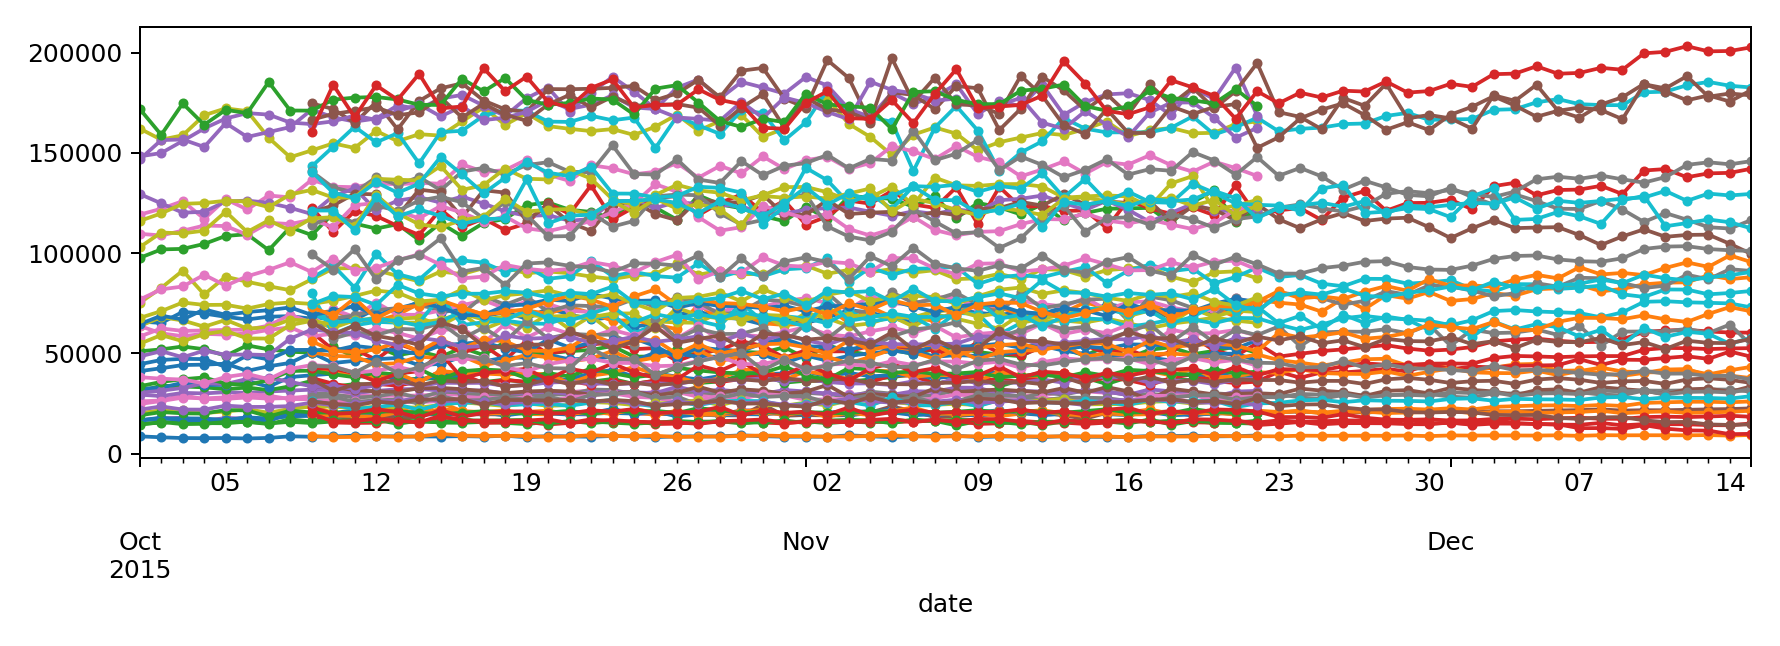

In [41]:
%matplotlib notebook
fitted_sarima_models = []
Dec15forecast = []
for column_name in time_series.shown.columns:
    _ = time_series.shown[column_name].plot(style=".-")
    forecasts = Forecasts[column_name]
    _ = forecasts.plot(style=".-", label="{} prediction".format(column_name))
    fitted_sarima_models.append(AdGroups[column_name].result_df.head(1))
    Dec15forecast.append(forecasts.values[-1])
time_series_result = pd.concat(fitted_sarima_models)

In [37]:
time_series_result["forecast_20151215"] = Dec15forecast
time_series_result["ad_group"] = time_series.shown.columns
time_series_result = time_series_result.sort_values("forecast_20151215", ascending=False).round(0)

In [38]:
data_20151122 = time_series.shown.iloc[-1,:].T.reset_index()
data_20151122.columns = ["ad", "data_20151122"]
forecast_summary = pd.merge(time_series_result, data_20151122, left_on="ad_group", right_on="ad")
print(forecast_summary.columns)
forecast_summary["ads_shown_lift"] = round((forecast_summary["forecast_20151215"]-forecast_summary["data_20151122"])\
/forecast_summary["data_20151122"] * 100,2).astype(str) + "%"
forecast_summary[["ad_group", "(p,d,q)x(P,D,Q)s", "AIC", "data_20151122", "forecast_20151215", "ads_shown_lift"]]\
.set_index("ad_group")

Index(['(p,d,q)x(P,D,Q)s', 'AIC', 'forecast_20151215', 'ad_group', 'ad',
       'data_20151122'],
      dtype='object')


(p,d,q)x(P,D,Q)s    AIC  data_20151122  forecast_20151215  \
ad_group                                                                      
ad_group_38  (0, 1, 0, 1, 1, 1, 7)  949.0       173351.0           202610.0   
ad_group_13  (0, 1, 0, 1, 1, 1, 7)  939.0       165662.0           182560.0   
ad_group_3   (0, 1, 0, 1, 1, 1, 7)  940.0       162434.0           181328.0   
ad_group_25  (0, 1, 1, 1, 1, 1, 7)  947.0       168502.0           178596.0   
ad_group_30  (0, 1, 0, 0, 1, 1, 7)  910.0       123653.0           145852.0   
ad_group_10  (0, 1, 1, 1, 1, 1, 7)  937.0       121324.0           142052.0   
ad_group_9   (2, 1, 2, 1, 1, 1, 7)  911.0       123598.0           129500.0   
ad_group_17  (1, 1, 1, 1, 1, 1, 7)  908.0       138435.0           116475.0   
ad_group_31  (2, 1, 2, 0, 1, 0, 7)  917.0       126477.0           112273.0   
ad_group_4   (0, 1, 0, 1, 1, 1, 7)  910.0        91684.0           101032.0   
ad_group_20  (2, 1, 2, 0, 1, 0, 7)  899.0       120779.0            99509.0   
ad_group_37  (2, 1, 2, 0, 1, 1, 7)  856.0        75605.0            95461.0   
ad_group_26  (2, 1, 2, 0, 1, 0, 7)  871.0        74800.0            91037.0   
ad_group_40  (2, 1, 2, 1, 1, 1, 7)  871.0        77907.0            90589.0   
ad_group_1   (2, 1, 2, 1, 1, 1, 7)  874.0        75829.0            87975.0   
ad_group_18  (0, 1, 0, 0, 1, 1, 7)  884.0        87391.0            81091.0   
ad_group_27  (1, 1, 1, 1, 1, 1, 7)  904.0        65196.0            72835.0   
ad_group_5   (2, 1, 2, 1, 1, 0, 7)  851.0        56566.0            70893.0   
ad_group_2   (1, 1, 0, 1, 1, 1, 7)  890.0        50115.0            60285.0   
ad_group_36  (2, 1, 2, 1, 1, 0, 7)  859.0        70553.0            57826.0   
ad_group_7   (0, 1, 1, 0, 1, 0, 7)  873.0        56528.0            57203.0   
ad_group_35  (1, 1, 0, 1, 1, 1, 7)  895.0        58802.0            53985.0   
ad_group_6   (0, 1, 0, 1, 1, 1, 7)  872.0        40800.0            52564.0   
ad_group_24  (2, 1, 2, 1, 1, 1, 7)  809.0        37743.0            48262.0   
ad_group_32  (1, 1, 0, 0, 1, 0, 7)  808.0        38336.0            43233.0   
ad_group_23  (1, 1, 1, 0, 1, 0, 7)  825.0        46368.0            37578.0   
ad_group_8   (2, 1, 2, 1, 1, 0, 7)  839.0        43832.0            36841.0   
ad_group_34  (2, 1, 2, 0, 1, 1, 7)  807.0        37536.0            35179.0   
ad_group_16  (1, 1, 0, 0, 1, 0, 7)  802.0        31246.0            33497.0   
ad_group_21  (0, 1, 0, 0, 1, 1, 7)  797.0        28481.0            32121.0   
ad_group_12  (1, 1, 1, 1, 1, 1, 7)  779.0        29480.0            30842.0   
ad_group_22  (0, 1, 1, 0, 1, 0, 7)  773.0        25536.0            28643.0   
ad_group_19  (0, 1, 1, 1, 1, 1, 7)  798.0        20971.0            25999.0   
ad_group_11  (0, 1, 0, 0, 1, 0, 7)  764.0        20437.0            22527.0   
ad_group_28  (0, 1, 0, 0, 1, 1, 7)  740.0        20390.0            21356.0   
ad_group_33  (1, 1, 0, 1, 1, 1, 7)  773.0        16430.0            18325.0   
ad_group_15  (1, 1, 1, 0, 1, 1, 7)  773.0        14873.0            15007.0   
ad_group_39  (2, 1, 2, 1, 1, 1, 7)  773.0        24202.0            14541.0   
ad_group_29  (0, 1, 0, 1, 1, 1, 7)  781.0        20144.0             9813.0   
ad_group_14  (0, 1, 1, 0, 1, 1, 7)  670.0         8967.0             9263.0   

            ads_shown_lift  
ad_group                    
ad_group_38         16.88%  
ad_group_13          10.2%  
ad_group_3          11.63%  
ad_group_25          5.99%  
ad_group_30         17.95%  
ad_group_10         17.08%  
ad_group_9           4.78%  
ad_group_17        -15.86%  
ad_group_31        -11.23%  
ad_group_4           10.2%  
ad_group_20        -17.61%  
ad_group_37         26.26%  
ad_group_26         21.71%  
ad_group_40         16.28%  
ad_group_1          16.02%  
ad_group_18         -7.21%  
ad_group_27         11.72%  
ad_group_5          25.33%  
ad_group_2          20.29%  
ad_group_36        -18.04%  
ad_group_7           1.19%  
ad_group_35         -8.19%  
ad_

The above is a summary about how many ads will be shown on Dec.15, 2015.

#### Part 3:
Cluster ads into 3 groups: the ones whose avg_cost_per_click is going up, the ones whose avg_cost_per_click is flat and the ones whose avg_cost_per_click is going down.

<IPython.core.display.Javascript object>


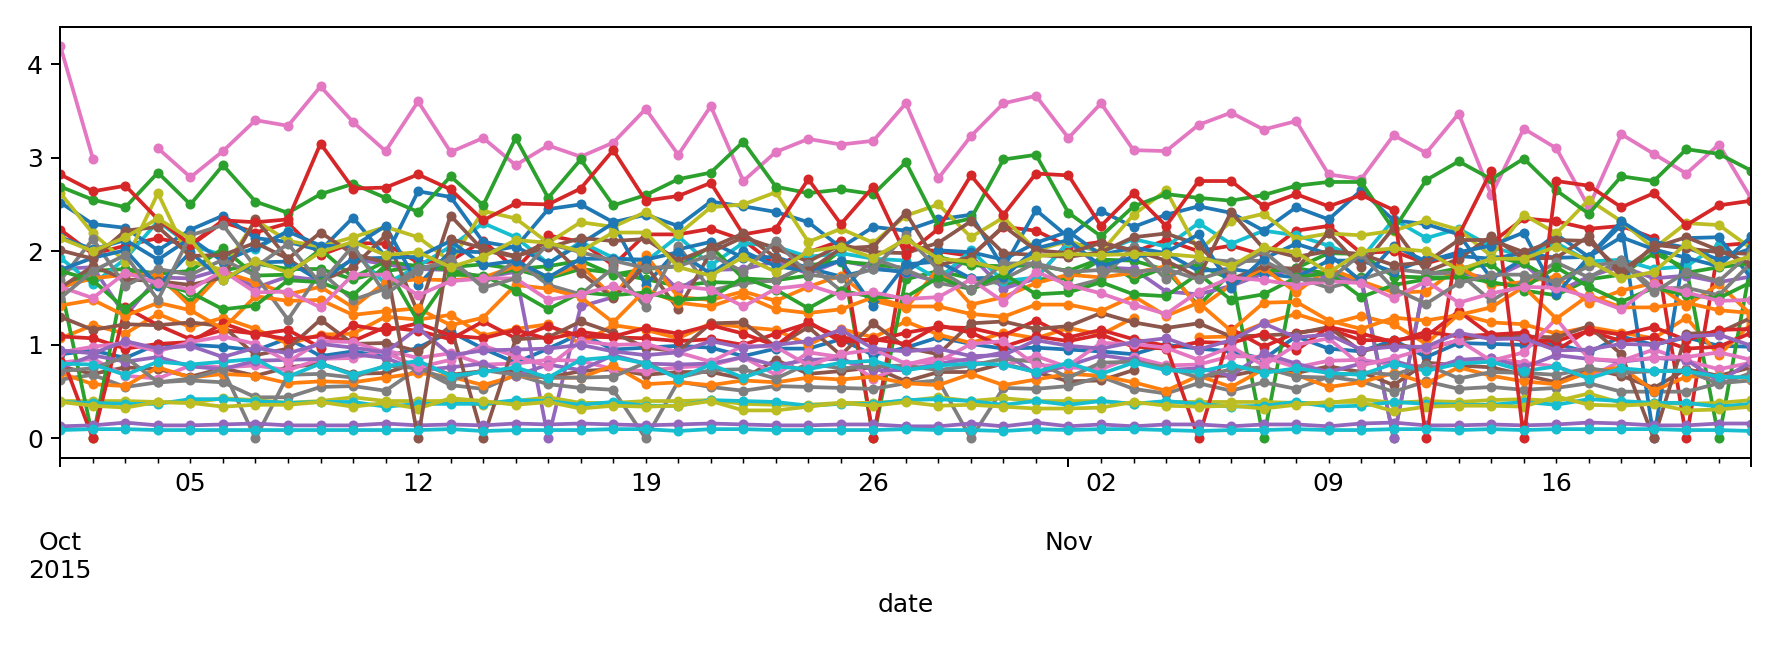

In [43]:
time_series2 = data.groupby("ad").apply(lambda df: df[["date","avg_cost_per_click"]]\
                         .sort_values("date").set_index("date")).unstack(0)
%matplotlib notebook
ax = time_series2.plot(style=".-")
ax.get_legend().remove()

Again, in the time series of avg_cost_per_click, we have zero values which should have been missing values. I still use the linear interpolation to impute all the missing values.

After the missing data imputation, I standardized the time series data with each time series mean value and standard deviation value, after which I did a gaussian kernel smoothing with standard deviation of 5.

<IPython.core.display.Javascript object>


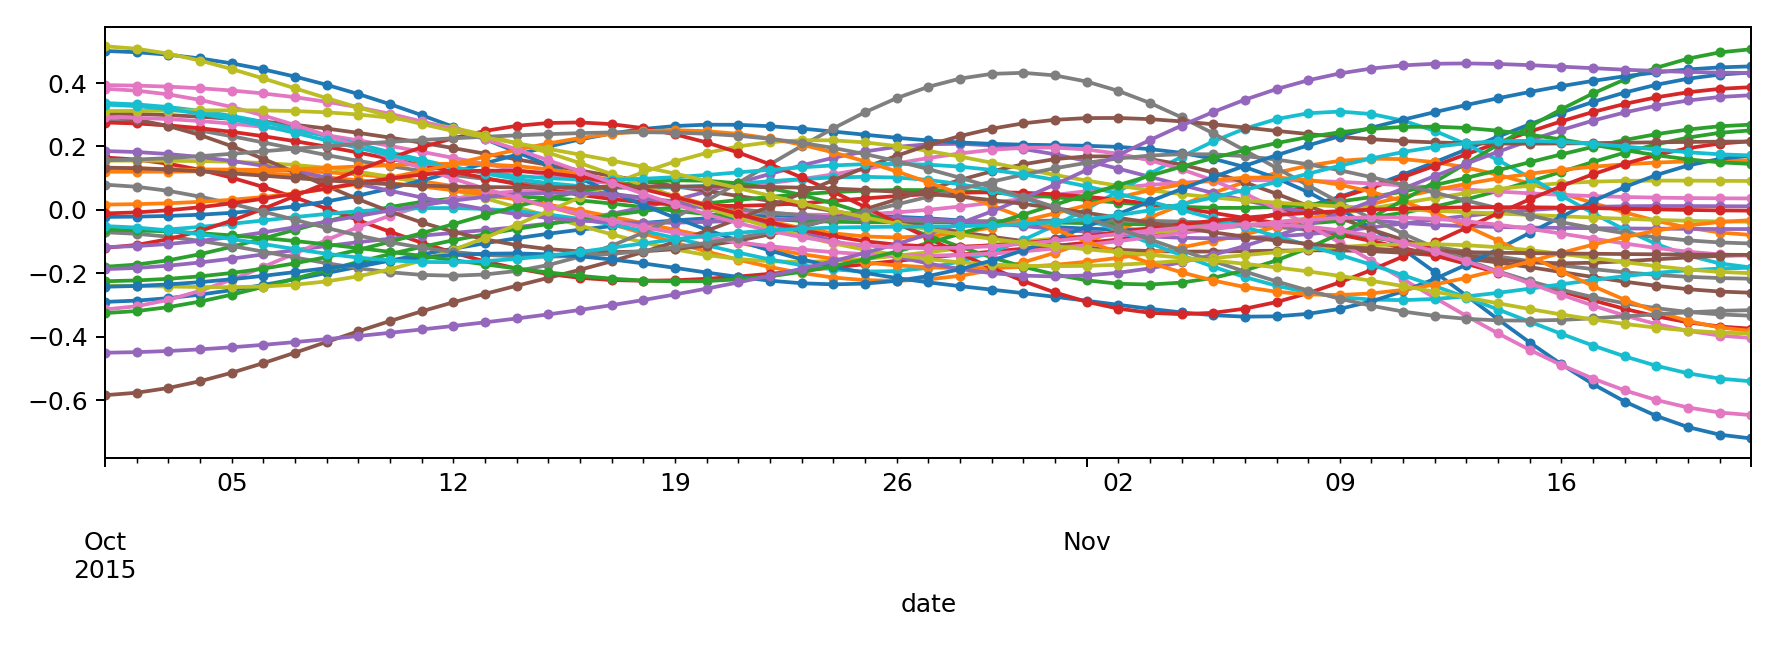

In [44]:
tss = time_series2.stack()
tss[tss.avg_cost_per_click==0]= np.nan
time_series2 = tss.unstack().apply(lambda s: s.interpolate(), axis=0)\
.apply(lambda s:gaussian_filter1d((s - s.mean())/s.std(), 7), axis=0)
ax = time_series2.plot(style=".-")
ax.get_legend().remove()

<IPython.core.display.Javascript object>


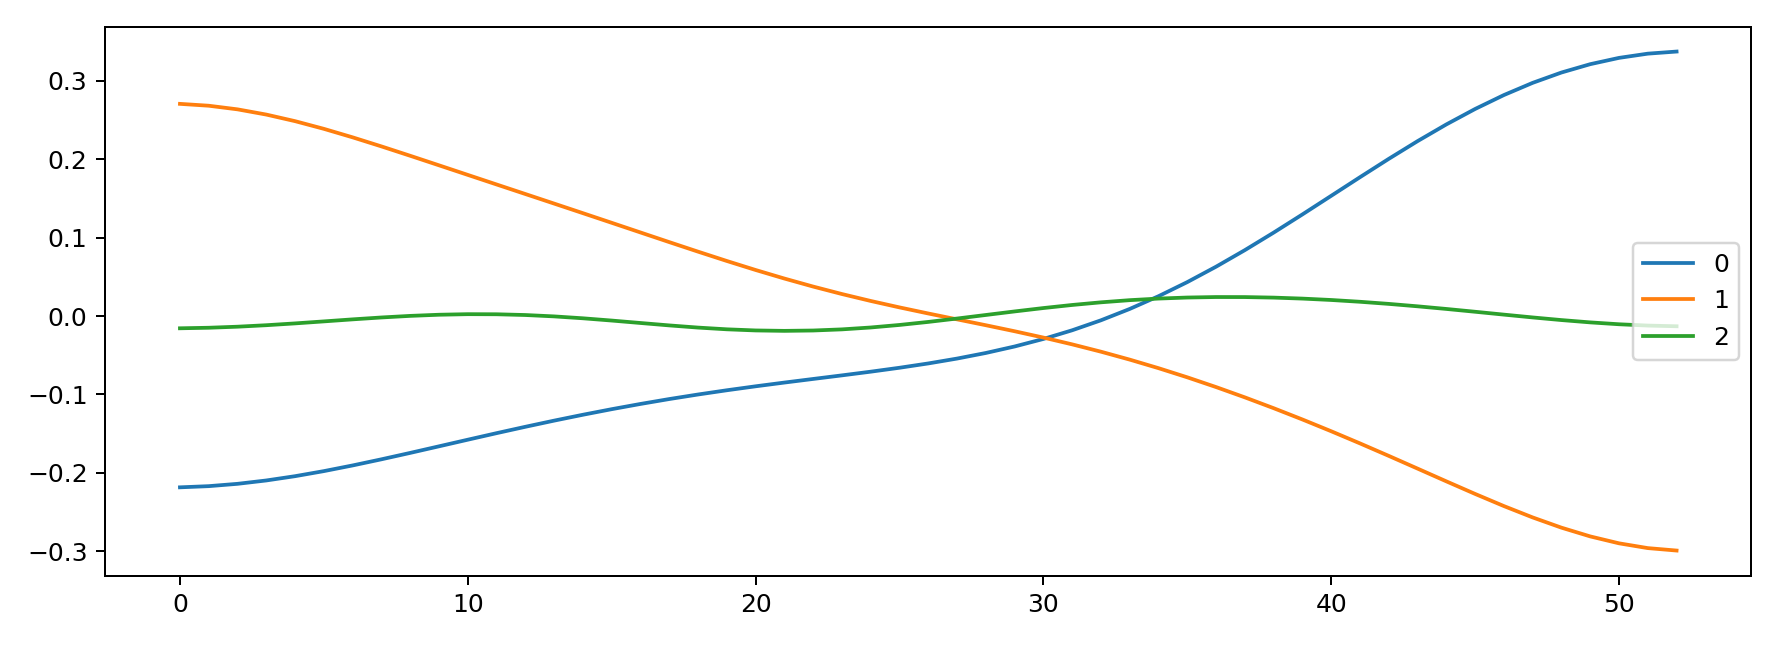

In [45]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(time_series2.T)
%matplotlib notebook
plt.plot(pd.DataFrame(kmeans.cluster_centers_).T)
plt.legend([0, 1, 2])

It is obvious from the visualization of the cluster centers, that the avg_cost_per_click in cluster "0" is going up; the avg_cost_per_click in cluster "1" is going down and the avg_cost_per_click of cluster "2" is flat. Since these cluster labels are readily available in the kmeans object for each ad group, we can extract this info and figure out which ad_groups have their avg_cost_per_click values going up, going down or flat.

In [46]:
cluster_table = pd.DataFrame({"ad": [y for x, y in time_series2.columns], "label": kmeans.labels_})

* ad_groups with avg_cost_per_click going up

In [47]:
cluster_table[cluster_table.label == 0].ad.values

array(['ad_group_1', 'ad_group_12', 'ad_group_20', 'ad_group_3',
       'ad_group_31', 'ad_group_32', 'ad_group_37', 'ad_group_39',
       'ad_group_40', 'ad_group_9'], dtype=object)

* ad_groups with avg_cost_per_click going down

In [48]:
cluster_table[cluster_table.label == 1].ad.values

array(['ad_group_14', 'ad_group_16', 'ad_group_19', 'ad_group_21',
       'ad_group_24', 'ad_group_27', 'ad_group_28', 'ad_group_29',
       'ad_group_33', 'ad_group_35', 'ad_group_36', 'ad_group_38',
       'ad_group_5', 'ad_group_6', 'ad_group_7', 'ad_group_8'],
      dtype=object)

* ad_groups with avg_cost_per_click being flat

In [49]:
cluster_table[cluster_table.label == 2].ad.values

array(['ad_group_10', 'ad_group_11', 'ad_group_13', 'ad_group_15',
       'ad_group_17', 'ad_group_18', 'ad_group_2', 'ad_group_22',
       'ad_group_23', 'ad_group_25', 'ad_group_26', 'ad_group_30',
       'ad_group_34', 'ad_group_4'], dtype=object)